In [1]:
import pandas as pd
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import PIL
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torchvision import utils
import torchvision.transforms as T
import time
from matplotlib.patches import Rectangle
import json
from torch.utils.data import DataLoader

data_path = "/home/kevin/deep_learning/wildcam_eccv/"

# Make WildCam Dataset

In [2]:
class WildcamDetectionDataset(Dataset):
    """Wildcam Image Dataset"""

    def __init__(self, label_file, root_dir, transform=None, transform_size=None):
        self.root_dir = root_dir
        self.transform = transform
        self.transform_size = transform_size
        with open(label_file) as f:
            labels = json.load(f)
        cats = pd.DataFrame(labels['categories'])
        df = pd.DataFrame.from_dict(labels['annotations'])
        # only keep pics with boxes
        keep = [type(elem) == list for elem in df['bbox']]
        df = df.loc[keep]
        print(df.shape)
        # get list of images
        self.images = list(df['image_id'])
        
        # generate labels
        # function for box adjustments
        def adjust_box(b):
            """ Adjust box format to x1, y1, x2, y2 instead of width and heigth"""
            if type(b) == list:
                b[2] = b[0] + b[2]
                b[3] = b[1] + b[3]
            else:
                b = []
            return b
        
        boxes = list(df['bbox'])
        boxes = [adjust_box(b) for b in boxes]
        boxes = [torch.Tensor(b) for b in boxes]
        boxes = torch.stack(boxes)

        # ids
        ids = list(df['category_id'])
        # change ids to all 1 as currently this dataset only contains boxes of animals
        ids = [1 for x in ids]
        
        # make list of dicts
        labels = []
        for i in range(len(boxes)):
            tmp = {'boxes': torch.stack([boxes[i]]),
                  'labels': torch.Tensor([ids[i]]).to(torch.int64)}
            labels.append(tmp)
        self.labels = labels

    
    def resize_bb(self, label, im_size):
        """Resize a bounding box"""
        for b in label['boxes']:
            x_ = self.transform_size / im_size[0]  
            y_ = self.transform_size / im_size[1]
            b[0] = b[0] * y_
            b[1] = b[1] * x_
            b[2] = b[2] * y_
            b[3] = b[3] * x_
        return label

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        """ Get an image"""
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Load image
        img = self.images[idx]+".jpg"
        image = Image.open(os.path.join(self.root_dir, img))
        label = self.labels[idx]

        # Apply transform
        if self.transform is not None:
            im_size = np.array(image).shape
            # Transform image
            image = self.transform(image)
            if self.transform_size is not None:
                # Resize labels    
                label = self.resize_bb(label, im_size)

        return {'image': image, 'label': label}

In [3]:
def wildcam_collate_fn(batch):
    imgs = [item['image'] for item in batch]
    targets = [item['label'] for item in batch]
    return imgs, targets


def dict_on_gpu(d, device):
    d['boxes'] = d['boxes'].to(device)
    d['labels'] = d['labels'].to(device)
    return(d)

def freeze_layers(model):
    "Freeze Backbone with FPN"
    for i, child in enumerate(model.children()):
        if i <= 1:
            for param in child.parameters():
                param.requires_grad = False
                
    return model

# Training
With a custom Dataset/DataLoader that works with the pre-trained FasterRCNN model, I can test around with training the model.

In [4]:
# Device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Get the model
n_classes = 2
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.train()
model.roi_heads.box_predictor.cls_score = nn.Linear(in_features=1024, out_features=n_classes, bias=True)
model.to(device)

# Freeze Backbone+FPN layers
model = freeze_layers(model)

# Create new dataset with bigger batches
root_dir = "/home/kevin/deep_learning/wildcam_eccv/eccv_18_cropped/"
label_file = os.path.join(data_path, "eccv_18_annotation_files/train_annotations.json")
batch_size = 4
transform = T.Compose([T.Resize((224, 224)),T.ToTensor()])
data = WildcamDetectionDataset(label_file=label_file, root_dir=root_dir, transform=transform, transform_size=224)
dataloader = DataLoader(data, batch_size=batch_size, shuffle=True, collate_fn=wildcam_collate_fn)

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

loss_list = []

for epoch in range(1):
    for i, batch in enumerate(dataloader):
        images = batch[0]
        labels = batch[1]
        images = [img.to(device) for img in images]
        labels = [dict_on_gpu(lab, device) for lab in labels]

        optimizer.zero_grad()
        
        loss_dict = model(images, labels)

        losses = sum(loss for loss in loss_dict.values())
        
        losses.backward()
        optimizer.step()
        
        if i % 50 == 0:
            print(f"Epoch: {epoch}, Step: {i}, Loss: {losses.item()}")
            loss_list.append(losses.item())

(12617, 4)
Epoch: 0, Step: 0, Loss: 0.8417607545852661
Epoch: 0, Step: 50, Loss: 0.18999320268630981
Epoch: 0, Step: 100, Loss: 0.11955330520868301
Epoch: 0, Step: 150, Loss: 0.09280276298522949
Epoch: 0, Step: 200, Loss: 0.17512951791286469
Epoch: 0, Step: 250, Loss: 0.15614072978496552
Epoch: 0, Step: 300, Loss: 0.0898667648434639
Epoch: 0, Step: 350, Loss: 0.09393692016601562
Epoch: 0, Step: 400, Loss: 0.11296218633651733
Epoch: 0, Step: 450, Loss: 0.06629734486341476
Epoch: 0, Step: 500, Loss: 0.13906285166740417
Epoch: 0, Step: 550, Loss: 0.17963911592960358
Epoch: 0, Step: 600, Loss: 0.19760392606258392
Epoch: 0, Step: 650, Loss: 0.13626933097839355
Epoch: 0, Step: 700, Loss: 0.16395261883735657
Epoch: 0, Step: 750, Loss: 0.09520147740840912
Epoch: 0, Step: 800, Loss: 0.10884687304496765
Epoch: 0, Step: 850, Loss: 0.08410545438528061
Epoch: 0, Step: 900, Loss: 0.12442710250616074
Epoch: 0, Step: 950, Loss: 0.10962427407503128
Epoch: 0, Step: 1000, Loss: 0.06621801108121872
Epoch:

# Evaluate trained model

[ 33.72647  113.83234   63.619385 156.03297 ]
tensor(1, device='cuda:0')
[ 22.904064  11.028512 209.44559  214.80605 ]
tensor(1, device='cuda:0')
[ 16.470133 117.61659   55.88859  160.6281  ]
tensor(1, device='cuda:0')


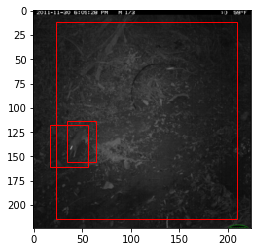

[ 23.674812 101.4744    40.64365  128.83762 ]
tensor(1, device='cuda:0')
[ 11.689711 103.24103   41.90159  133.40543 ]
tensor(1, device='cuda:0')
[ 16.407839    7.5322804 210.05429   224.       ]
tensor(1, device='cuda:0')
[186.83223  121.212715 221.68289  160.34143 ]
tensor(1, device='cuda:0')
[ 96.09616   50.921257 154.91365   94.407326]
tensor(1, device='cuda:0')
[  6.738786 109.088905  45.409424 146.18553 ]
tensor(1, device='cuda:0')


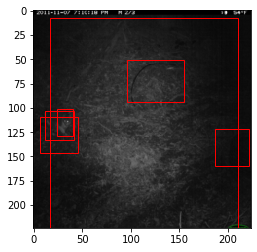

[ 38.323326   0.       206.42383  224.      ]
tensor(1, device='cuda:0')
[55.42881 47.90725 85.00129 81.34981]
tensor(1, device='cuda:0')
[138.79266 123.75071 156.00934 139.78847]
tensor(1, device='cuda:0')
[60.354763 50.208164 76.267136 85.02339 ]
tensor(1, device='cuda:0')
[134.73776  84.11344 161.14517  99.51325]
tensor(1, device='cuda:0')
[ 98.75682   50.152153 159.80797  107.14008 ]
tensor(1, device='cuda:0')


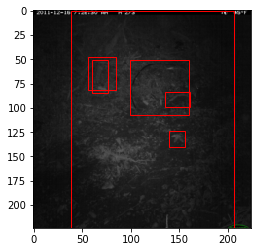

[106.8544  113.09119 137.5287  167.74648]
tensor(1, device='cuda:0')
[198.30286  123.504364 224.       179.88045 ]
tensor(1, device='cuda:0')
[ 11.762469   4.457288 178.24098  215.46225 ]
tensor(1, device='cuda:0')
[  6.7876244 189.12799    48.98452   223.60739  ]
tensor(1, device='cuda:0')
[  6.798688 176.91464   65.34915  220.267   ]
tensor(1, device='cuda:0')


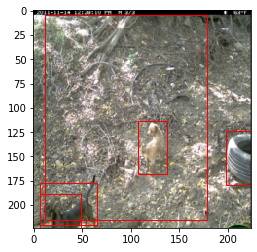

[106.8544  113.09119 137.5287  167.74648]
tensor(1, device='cuda:0')
[198.30286  123.504364 224.       179.88045 ]
tensor(1, device='cuda:0')
[ 11.762469   4.457288 178.24098  215.46225 ]
tensor(1, device='cuda:0')
[  6.7876244 189.12799    48.98452   223.60739  ]
tensor(1, device='cuda:0')
[  6.798688 176.91464   65.34915  220.267   ]
tensor(1, device='cuda:0')


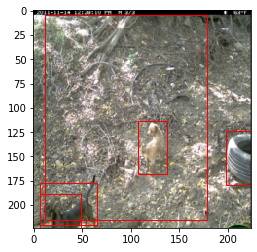

[ 39.642292 115.35756   75.91983  145.77545 ]
tensor(1, device='cuda:0')
[ 11.794624  12.07365  214.14568  221.28012 ]
tensor(1, device='cuda:0')
[127.234215  83.68735  160.46678  109.48128 ]
tensor(1, device='cuda:0')
[184.17256 188.2928  223.65324 221.19028]
tensor(1, device='cuda:0')


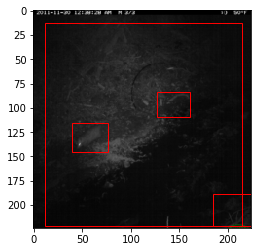

[ 53.33619   73.385284  83.60791  121.35474 ]
tensor(1, device='cuda:0')
[ 73.192604  81.45311  113.529816 115.15857 ]
tensor(1, device='cuda:0')
[155.86804   33.694195 185.13611   63.121193]
tensor(1, device='cuda:0')
[ 10.735926   3.121554 207.5258   214.73221 ]
tensor(1, device='cuda:0')
[164.75867   33.493168 179.5596    61.046154]
tensor(1, device='cuda:0')
[104.20112  67.8545  135.76988 101.04619]
tensor(1, device='cuda:0')


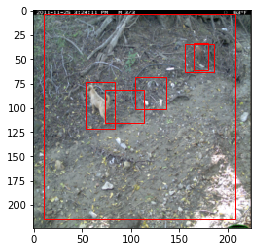

[198.78496  124.849144 222.96593  170.68376 ]
tensor(1, device='cuda:0')
[127.18064  89.4777  155.50914 123.14539]
tensor(1, device='cuda:0')
[ 43.40542    8.309236 202.24493  199.87917 ]
tensor(1, device='cuda:0')
[195.17644  79.5616  222.50006 175.26117]
tensor(1, device='cuda:0')
[168.74669 131.18471 202.01183 166.97163]
tensor(1, device='cuda:0')


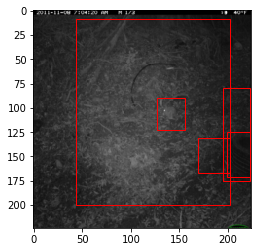

[103.07609  68.61855 137.41852 103.74076]
tensor(1, device='cuda:0')
[165.27559   31.571285 179.27966   60.81373 ]
tensor(1, device='cuda:0')
[166.82916  64.72442 177.20328  83.02337]
tensor(1, device='cuda:0')
[ 98.73977  100.00354  115.876305 126.03063 ]
tensor(1, device='cuda:0')
[ 21.372135 150.0448    34.10175  165.34561 ]
tensor(1, device='cuda:0')


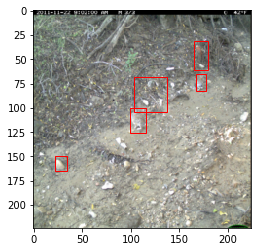

[103.07609  68.61855 137.41852 103.74076]
tensor(1, device='cuda:0')
[165.27559   31.571285 179.27966   60.81373 ]
tensor(1, device='cuda:0')
[166.82916  64.72442 177.20328  83.02337]
tensor(1, device='cuda:0')
[ 98.73977  100.00354  115.876305 126.03063 ]
tensor(1, device='cuda:0')
[ 21.372135 150.0448    34.10175  165.34561 ]
tensor(1, device='cuda:0')


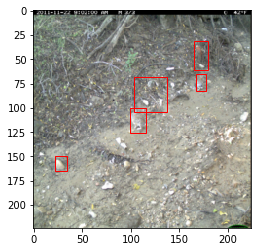

In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
dataloader = DataLoader(data, batch_size=1, shuffle=False, collate_fn=wildcam_collate_fn)
it = iter(dataloader)
## a few examples
model.eval()
model.to(device)

for i in range(10):
    sample = next(it)
    image = [x.to(device) for x in sample[0]]
    pred = model(image)
    pred_boxes = pred[0]['boxes'].cpu().detach().numpy()
    labels = pred[0]['labels']
    plt.imshow(sample[0][0].permute(1, 2, 0))
    
    # Get the current reference
    ax = plt.gca()

    for i in range(len(pred_boxes)):
        box = pred_boxes[i]
        lab = labels[i]
        print(box)
        print(lab)
        box_width = box[2] - box[0]
        box_height = box[3] - box[1]

        # Create a Rectangle patch
        rect = Rectangle((box[0],box[1]),box_width, box_height,linewidth=1,edgecolor='r',facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)
    plt.show()

[ 35.873043 119.040054  60.00176  159.36646 ]
tensor(3)
[ 38.48162  119.241104 101.39376  158.55905 ]
tensor(3)
[ 33.12304   36.300957 195.55367  181.49075 ]
tensor(4)
[ 32.01015  36.23018 193.25397 178.43013]
tensor(2)
[ 27.117155  30.216253 204.01802  181.93092 ]
tensor(3)


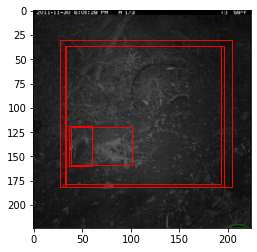

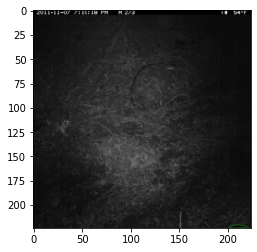

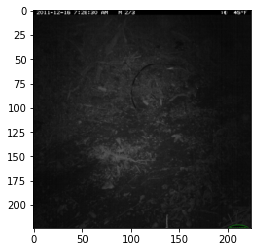

[109.243805 116.015945 135.35081  164.70667 ]
tensor(18)
[198.19044  127.508965 223.64624  179.78133 ]
tensor(51)
[198.21507 128.03629 223.18433 180.00746]
tensor(86)
[106.8574   115.342896 135.12888  167.52182 ]
tensor(16)


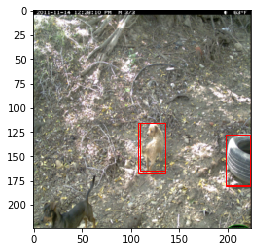

[109.243805 116.015945 135.35081  164.70667 ]
tensor(18)
[198.19044  127.508965 223.64624  179.78133 ]
tensor(51)
[198.21507 128.03629 223.18433 180.00746]
tensor(86)
[106.8574   115.342896 135.12888  167.52182 ]
tensor(16)


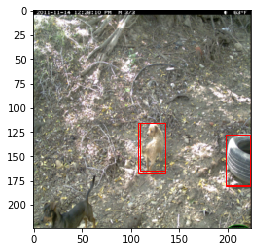

[ 42.412083 116.272995  73.48794  144.89883 ]
tensor(39)


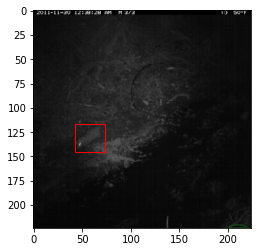

[ 54.87648  75.83013  81.30799 119.40882]
tensor(18)
[ 54.17486   75.945015  81.33866  116.6351  ]
tensor(20)
[ 54.1215    76.21281   81.854385 120.01938 ]
tensor(16)


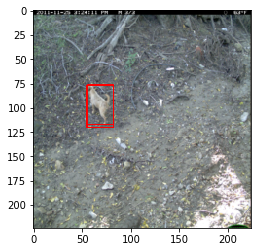

In [ ]:
device = "cpu"
model2 = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
it = iter(dataloader)
## a few examples
model2.eval()
model2.to(device)

for i in range(10):
    sample = next(it)
    image = [x.to(device) for x in sample[0]]
    pred = model2(image)
    pred_boxes = pred[0]['boxes'].cpu().detach().numpy()
    labels = pred[0]['labels']
    plt.imshow(sample[0][0].permute(1, 2, 0))
    
    # Get the current reference
    ax = plt.gca()

    for i in range(len(pred_boxes)):
        box = pred_boxes[i]
        lab = labels[i]
        print(box)
        print(lab)
        box_width = box[2] - box[0]
        box_height = box[3] - box[1]

        # Create a Rectangle patch
        rect = Rectangle((box[0],box[1]),box_width, box_height,linewidth=1,edgecolor='r',facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)
    plt.show()